# Cups
Generate synthetic data to even out class imbalance in the dataset

In [1]:
import numpy as np
import pandas as pd
import math
from random import sample
import matplotlib.pyplot as plt

import imgaug.augmenters as iaa
import imgaug
from skimage import io

In [2]:
#data_dir = '/run/user/1000/gvfs/smb-share:server=titan.local,share=datasets/kitchenware-classification' 
data_dir = 'data'
image_width = 600
image_height = 600
channels = 3

In [3]:
df_train_full = pd.read_csv(data_dir+'/train.csv', dtype={'Id': str})
df_extra = pd.read_csv(data_dir+'/data.csv', dtype={'Id': str})
df_train_full = pd.concat([df_train_full, df_extra], ignore_index = True)
df_train_full['filename'] = data_dir+'/images/' + df_train_full['Id'] + '.jpg'
df_train_full.head()

,Id,label,filename
0,0560,glass,data/images/0560.jpg
1,4675,cup,data/images/4675.jpg
2,0875,glass,data/images/0875.jpg
3,4436,spoon,data/images/4436.jpg
4,8265,plate,data/images/8265.jpg


In [4]:
df_train_full.label.unique()

array(['glass', 'cup', 'spoon', 'plate', 'knife', 'fork'], dtype=object)

In [5]:
df_train_full.label.value_counts()

plate    1698
cup      1625
spoon    1512
knife    1357
glass    1020
fork      776
Name: label, dtype: int64

In [6]:
df_cup = df_train_full.query('label == "cup"').copy()
df_cup.reset_index(drop=True, inplace = True)
df_cup

,Id,label,filename
0,4675,cup,data/images/4675.jpg
1,2422,cup,data/images/2422.jpg
2,8882,cup,data/images/8882.jpg
3,8705,cup,data/images/8705.jpg
4,5952,cup,data/images/5952.jpg
...,...,...,...
1620,eu.aabf9d03-21a8-4b1b-9bc0-633bf6406553,cup,data/images/eu.aabf9d03-21a8-4b1b-9bc0-633bf64...
1621,eu.067905cf-81e9-47f4-9d1e-206699d253a1,cup,data/images/eu.067905cf-81e9-47f4-9d1e-206699d...
1622,eu.9e603ed2-fc68-4ed2-a90b-3be5e1a1703f,cup,data/images/eu.9e603ed2-fc68-4ed2-a90b-3be5e1a...
1623,eu.65e9264e-d366-437d-ab8a-29536351c3b2,cup,data/images/eu.65e9264e-d366-437d-ab8a-2953635...


In [7]:
cups = []
for filename in df_cup.filename:
    image = io.imread(filename)
    cups.append(image)


In [8]:
train_aug = iaa.Sequential(
    [
        iaa.Resize({"height": image_height, "width": image_width}, interpolation=imgaug.ALL),
        iaa.Fliplr(1),
        iaa.Flipud(1), 
        iaa.Sometimes(0.3, iaa.Cutout(nb_iterations = (2, 5), size = (.1, .2))),
        iaa.Sometimes(0.5, iaa.GammaContrast((0.5, 2.0), per_channel=True)),
        iaa.Sometimes(0.5, iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 30))),
        iaa.Sometimes(0.7, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        iaa.Sometimes(0.4, iaa.imgcorruptlike.GaussianNoise(severity=(1,4))),
        iaa.Sometimes(0.3, iaa.AllChannelsCLAHE(clip_limit=(1, 10), per_channel=True)),
    ],
    random_order=True,
    name = "train_aug"
)

In [12]:
cups_aug = train_aug(images = sample(cups, 75))

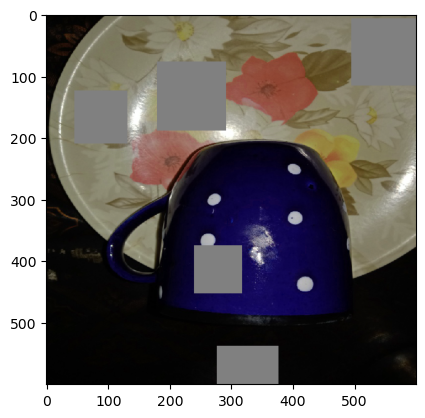

In [14]:
image = cups_aug[72]
plt.imshow(image)

In [15]:
np.asarray(cups_aug).shape

(75, 600, 600, 3)

In [16]:
len(cups_aug)

75

In [17]:
df_cup_aug = pd.DataFrame(columns = ['Id', 'label'], dtype = str)
for i in range(len(cups_aug)):
    file_name = 'cup_aug_'+str(i)
    io.imsave(data_dir+'/images/'+file_name+'.jpg', cups_aug[i])
    df_cup_aug.loc[len(df_cup_aug)] = ['cup_aug_'+str(i), 'cup']
    
df_cup_aug

,Id,label
0,cup_aug_0,cup
1,cup_aug_1,cup
2,cup_aug_2,cup
3,cup_aug_3,cup
4,cup_aug_4,cup
...,...,...
70,cup_aug_70,cup
71,cup_aug_71,cup
72,cup_aug_72,cup
73,cup_aug_73,cup


In [18]:
df_cup_aug.to_csv(data_dir+'/cup_aug.csv', index = False)

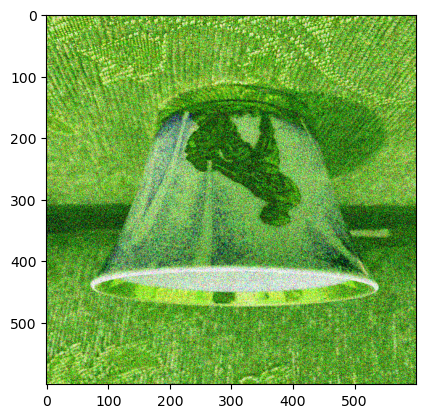

In [19]:
image = cups_aug[68]
plt.imshow(image)